In [1]:
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.datasets
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

In this chapter, we will start by looking at the Linear Regression model, one of the simplest models there is. We will discuss two very different ways to train it:
- Using a direct “closed-form” equation that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training set).
- Using an iterative optimization approach, called `Gradient Descent` (GD), that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method. We will look at a few variants of Gradient Descent that we will use again and again when we study neural networks in Part II: `Batch GD`, `Mini-batch GD`, and `Stochastic GD`.

Next we will look at `Polynomial Regression`, a more complex model that can fit non‐linear datasets. Since this model has more parameters than `Linear Regression`, it is more prone to overfitting the training data, so we will look at how to detect whether or not this is the case, using learning curves, and then we will look at several regularization techniques that can reduce the risk of overfitting the training set.

Finally, we will look at two more models that are commonly used for classification tasks: `Logistic Regression` and `Softmax Regression`.


## 4.1 Linear Regression
A linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the `bias` term (also called the `intercept` term):
- $\hat{y} = \theta_0 + \theta_1x_1 + \theta_2x_2 + ⋯ + \theta_nx_n$
> - $\hat{y}$ is the predicted value.
> - $n$ is the number of features.
> - $x_i$ is the $i^{th}$ feature value.
> - $\theta_j$ is the $j^{th}$ model parameter (including the bias term $\theta_0$ and the feature weights $\theta_1$, $\theta_2$, ⋯, $\theta_n$).

This can be written much more concisely using a vectorized form:
- $\hat{y} = h_{\theta}(x) = \theta^{T} \cdot x$
> $\theta$ is the model’s parameter vector, containing the bias term $\theta_0$ and the feature weights $\theta_1$, $\theta_2$, ⋯, $\theta_n$).
> - $\theta^T$ is the transpose of $\theta$ (a row vector instead of a column vector).
> - $x$ is the instance’s feature vector, containing $x_0$ to $x_n$, with $x_0$ always equal to 1.
> - $\theta^T \cdot x$ is the dot product of $\theta^T$ and $x$.
> - $h_{\theta}(x)$ is the hypothesis function, using the model parameters $\theta$.

Okay, that’s the Linear Regression model, so now how do we train it? Well, recall that training a model means setting its parameters so that the model best fits the training set. For this purpose, we first need a measure of how well the model fits the training data. In `Chapter 2` we saw that the most common performance measure of a regression model is the `Root Mean Square Error` (RMSE). Therefore, to train a Linear Regression model, you need to find the value of $\theta$ that minimizes the `RMSE`. In practice, it is simpler to minimize the `Mean Square Error` (MSE) than the RMSE, and it leads to the same result (because the value that minimizes a function also minimizes its square root):
- $MSE(X, h_{\theta}) = \frac{1}{m} \sum_{i=1}^{m}(\theta^T\cdot x^{(i)} - y^{(i)})^2$

### 4.1.1 The Normal Equation
To find the value of $\theta$ that minimizes the cost function, there is a closed-form solution -- in other words, a mathematical equation that gives the result directly. This is called the Normal Equation:
- $\hat{\theta} = (X^T \cdot X)^{-1} \cdot X^T \cdot y$
> - $\hat{\theta}$ is the value of $\theta$ that minimizes the cost function.
> - $y$ is the vector of target values containing $y^{(1)}$ to $y^{(m)}$.

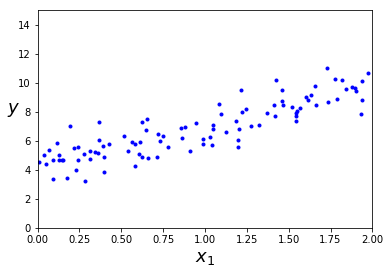

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [3]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[ 4.21509616],
       [ 2.77011339]])

The actual function is $y = 4 + 3x_0 + Gaussian\_noise$. Let’s see what the equation found, we would have hoped for $\theta_0 = 4$ and $\theta_1 = 3$ instead of $\theta_0 = 3.865$ and $\theta_1 = 3.139$. Close enough, but the noise made it impossible to recover the exact parameters of the original function.

Now you can make predictions using $\hat{\theta}$:

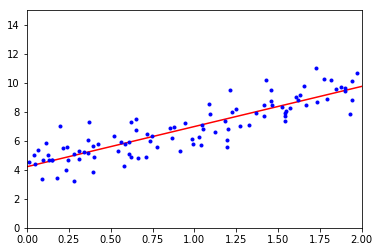

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

The equivalent code using Scikit-Learn looks like this:

In [5]:
lin_reg = sklearn.linear_model.LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 4.21509616]), array([[ 2.77011339]]))

### 4.1.2 Computational Complexity
The Normal Equation computes the inverse of $X^T \cdot X$, which is an $n*n$ matrix (where n is the number of features). The computational complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$ (depending on the implementation). In other words, if you double the number of features, you multiply the computation time by roughly $2^{2.4} = 5.3$ to $2^3 = 8$.

On the positive side, this equation is linear with regards to the number of instances in the training set (it is $O(m)$), so it handles large training sets efficiently, provided they can fit in memory.

Also, once you have trained your Linear Regression model (using the Normal Equation or any other algorithm), predictions are very fast: the computational complexity is linear with regards to both the number of instances you want to make predictions on and the number of features. In other words, making predictions on twice as many instances (or twice as many features) will just take roughly twice as much time.

Now we will look at very different ways to train a Linear Regression model, better suited for cases where there are a large number of features, or too many training instances to fit in memory.

## 4.2 Gradient Descent
`GD` is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of `GD` is to tweak parameters iteratively in order to minimize a cost function.

Suppose you are lost in the mountains in a dense fog; you can only feel the slope of the ground below your feet. A good strategy to get to the bottom of the valley quickly is to go downhill in the direction of the steepest slope. This is exactly what `GD` does: it measures the local gradient of the error function with regards to the parameter vector $\theta$, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!

Concretely, you start by filling $\theta$ with random values, and then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum (see `Figure 4-3`):
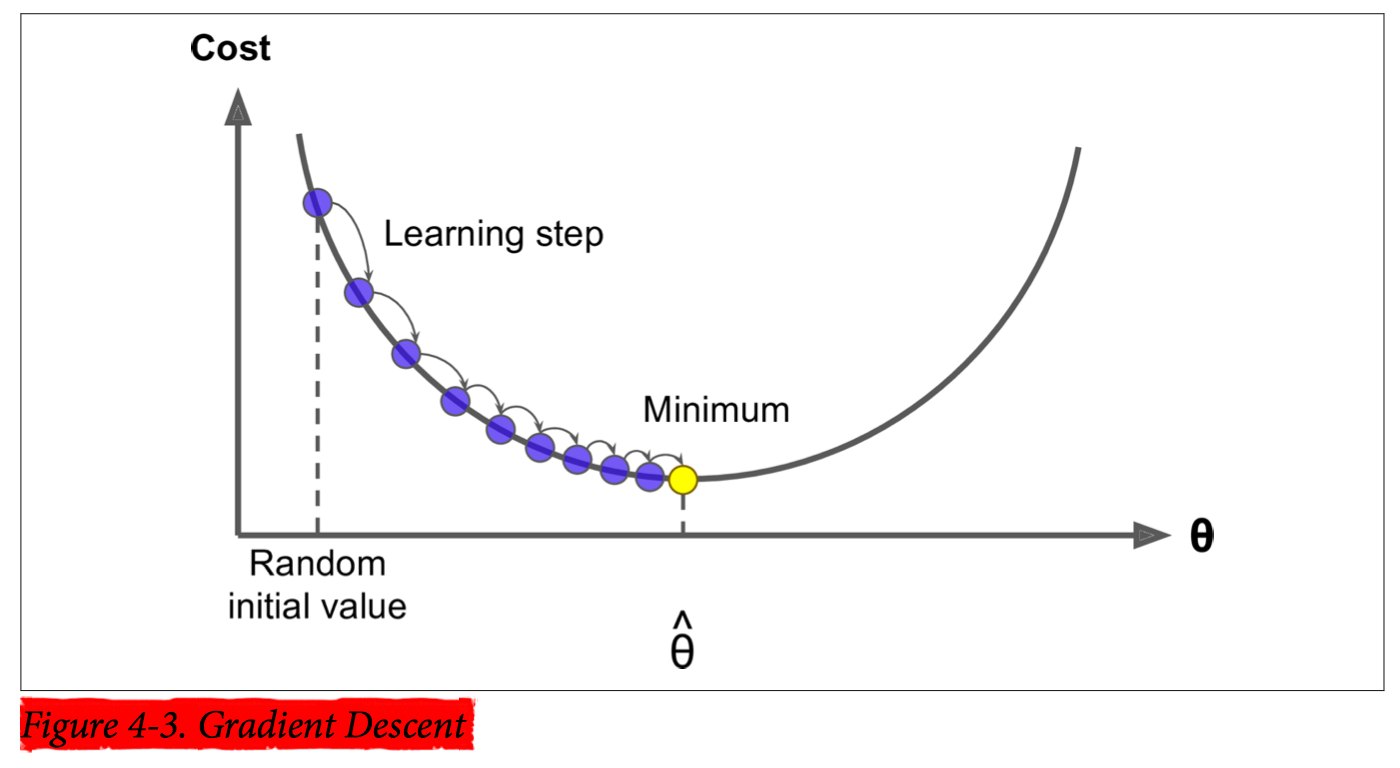

An important parameter in `GD` is the size of the steps, determined by the learning rate hyperparameter. If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time (see `Figure 4-4`):
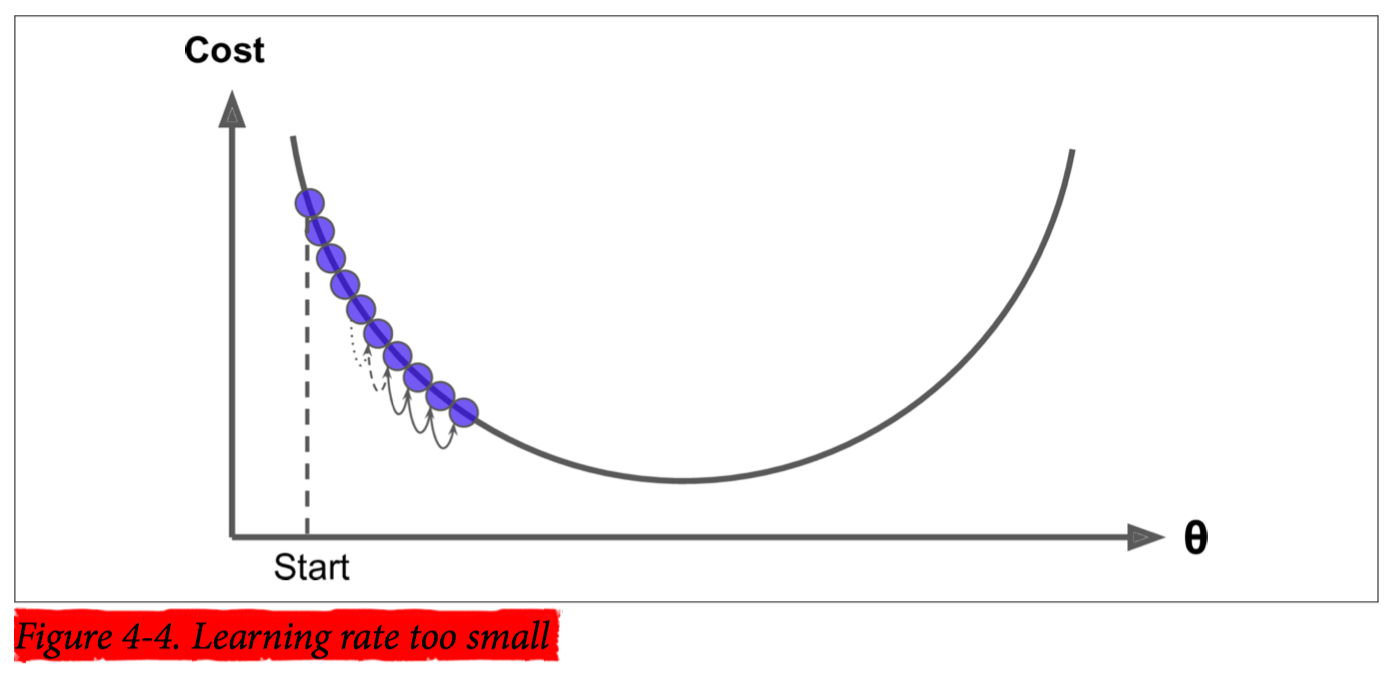

On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution (see `Figure 4-5`):
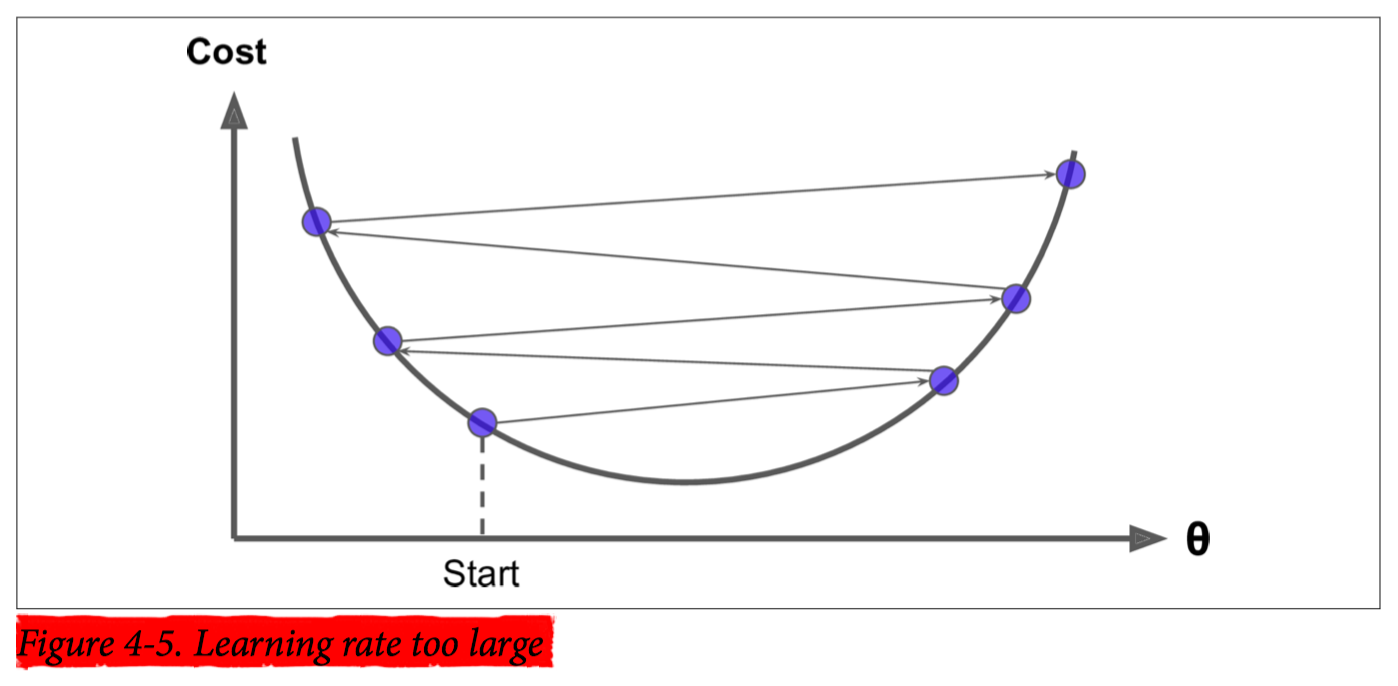

Finally, not all cost functions look like nice regular bowls. There may be holes, ridges, plateaus, and all sorts of irregular terrains, making convergence to the minimum very difficult. `Figure 4-6` shows the two main challenges with `GD`: 
1. if the random initialization starts the algorithm on the left, then it will converge to a local minimum, which is not as good as the global minimum. 
2. If it starts on the right, then it will take a very long time to cross the plateau, and if you stop too early you will never reach the global minimum.

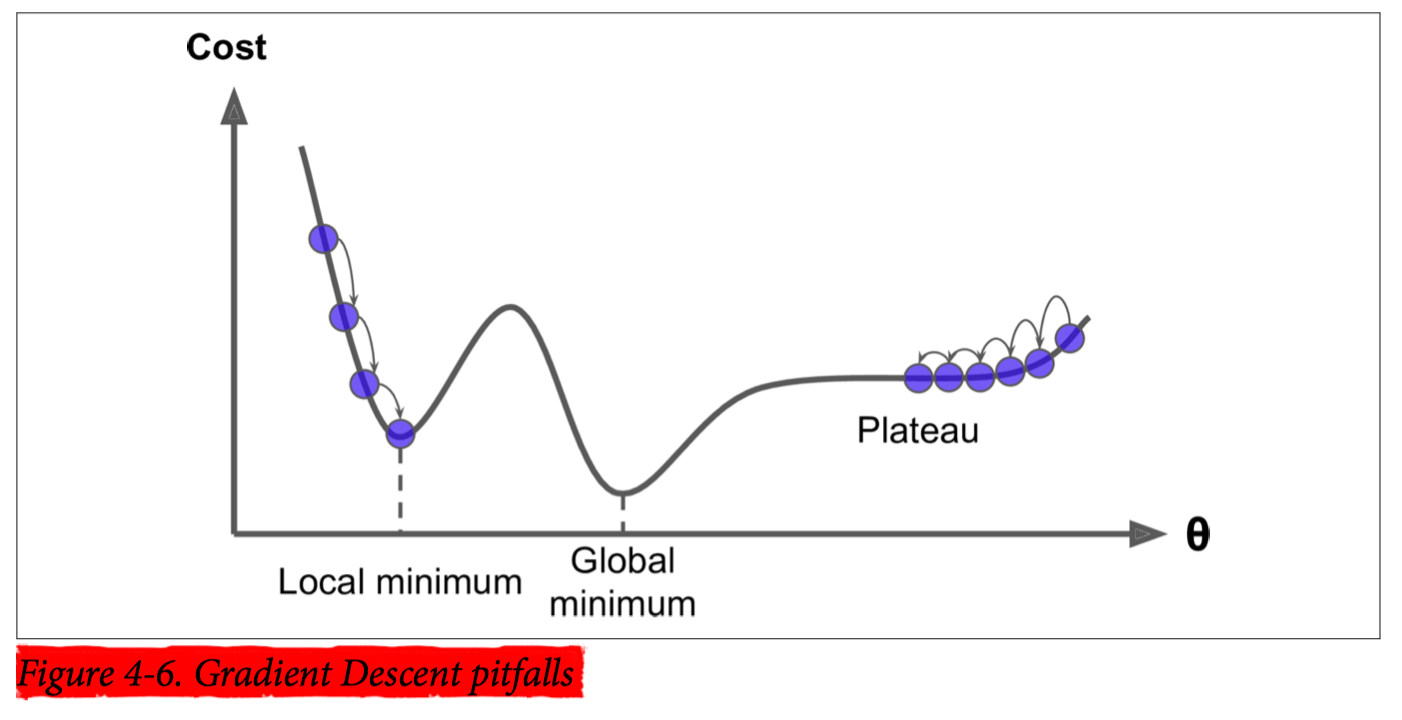

Fortunately, the `MSE` cost function for a Linear Regression model happens to be a `convex function`, which means that if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies that there are no local minima, just one global minimum. It is also a continuous function with a slope that never changes abruptly. These two facts have a great consequence: `GD` is guaranteed to approach arbitrarily close the global minimum (if you wait long enough and if the learning rate is not too high).

In fact, the cost function has the shape of a bowl, but it can be an elongated bowl if the features have very different scales. `Figure 4-7` shows `GD` on a training set where features 1 and 2 have the same scale (on the left), and on a training set where feature 1 has much smaller values than feature 2 (on the right):
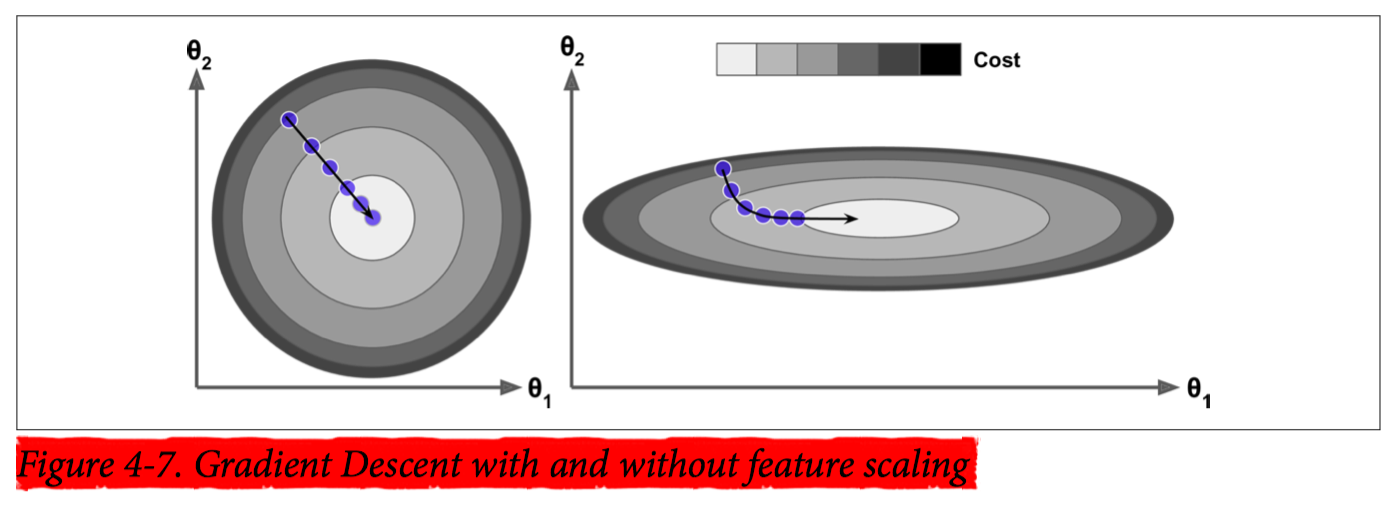

As you can see, on the left the `GD` algorithm goes straight toward the minimum, thereby reaching it quickly, whereas on the right it first goes in a direction almost orthogonal to the direction of the global minimum, and it ends with a long march down an almost flat valley. It will eventually reach the minimum, but it will take a long time.

> When using `GD`, you should ensure that all features have a similar scale, or else it will take much longer to converge.

This diagram also illustrates the fact that training a model means searching for a combination of model parameters that minimizes a cost function (over the training set). It is a search in the model’s parameter space: the more parameters a model has, the more dimensions this space has, and the harder the search is: searching for a needle in a 300-dimensional haystack is much trickier than in three dimensions. Fortunately, since the cost function is convex in the case of Linear Regression, the needle is simply at the bottom of the bowl.

### 4.2.1 Batch Gradient Descent
To implement `GD`, you need to compute the gradient of the cost function with regards to each model parameter $\theta_j$. In other words, you need to calculate how much the cost function will change if you change $\theta_j$ just a little bit. This is called a `partial derivative`:
- $\frac{\partial}{\partial\theta_j}MSE(\theta) = \frac{2}{m}\sum_{i=1}^{m}(\theta^T\cdot x^{(i)} - y^{(i)})x^{(i)}_j$

Instead of computing these gradients individually, you can use compute them all in one go:
- $\nabla\theta MSE(\theta) = \frac{2}{m}X^T\cdot (X\cdot \theta - y)$

> Notice that this formula involves calculations over the full training set X, at each `GD` step! This is why the algorithm is called `Batch GD`: it uses the whole batch of training data at every step. As a result it is terribly slow on very large training sets. However, `GD` scales well with the number of features; training a Linear Regression model when there are hundreds of thousands of features is much faster using `GD` than using the Normal Equation.

Once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill. This means subtracting $\nabla_\theta MSE(\theta)$ from $\theta$. This is where the learning rate $\eta$ comes into play: multiply the gradient vector by $\eta$ to determine the size of the downhill step:
- $\theta^{next\_step} = \theta - \eta \nabla_\theta MSE(\theta)$

Let’s look at a quick implementation of this algorithm:

In [6]:
eta = 0.1 # learning rate 
n_iterations = 1000 
m = 100

theta = np.random.randn(2,1)

# random initialization
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y) 
    theta = theta - eta * gradients

theta

array([[ 4.21509616],
       [ 2.77011339]])

`GD` worked perfectly. But what if you had used a different learning rate eta? `Figure 4-8` shows the first 10 steps of `GD` using three different learning rates (the dashed line represents the starting point):

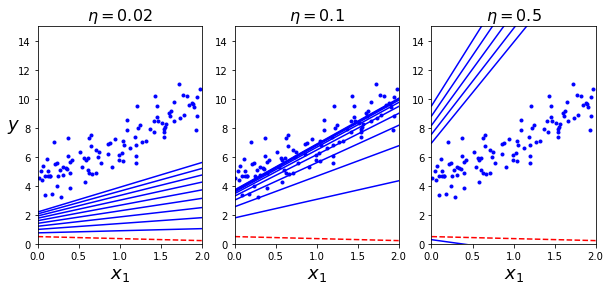

In [7]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

- On the left, the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time. 
- In the middle, the learning rate looks pretty good: in just a few iterations, it has already converged to the solution. 
- On the right, the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step.

To find a good learning rate, you can use grid search. However, you may want to limit the number of iterations so that grid search can eliminate models that take too long to converge.

You may wonder how to set the number of iterations. If it is too low, you will still be far away from the optimal solution when the algorithm stops, but if it is too high, you will waste time while the model parameters do not change anymore. A simple solution is to set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny -- that is, when its norm becomes smaller than a tiny number $\epsilon$ (called the tolerance)—because this happens when `GD` has (almost) reached the minimum.


## 4.2.2 Stochastic Gradient Descent
The main problem with `Batch GD` is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, `Stochastic GD` just picks a random instance in the training set at every step and computes the gradients based only on that single instance. Obviously this makes the algorithm much faster since it has very little data to manipulate at every iteration.

On the other hand, due to its stochastic nature, this algorithm is much less regular than `Batch GD`: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down (see Figure 4-9). So once the algorithm stops, the final parameter values are good, but not optimal:
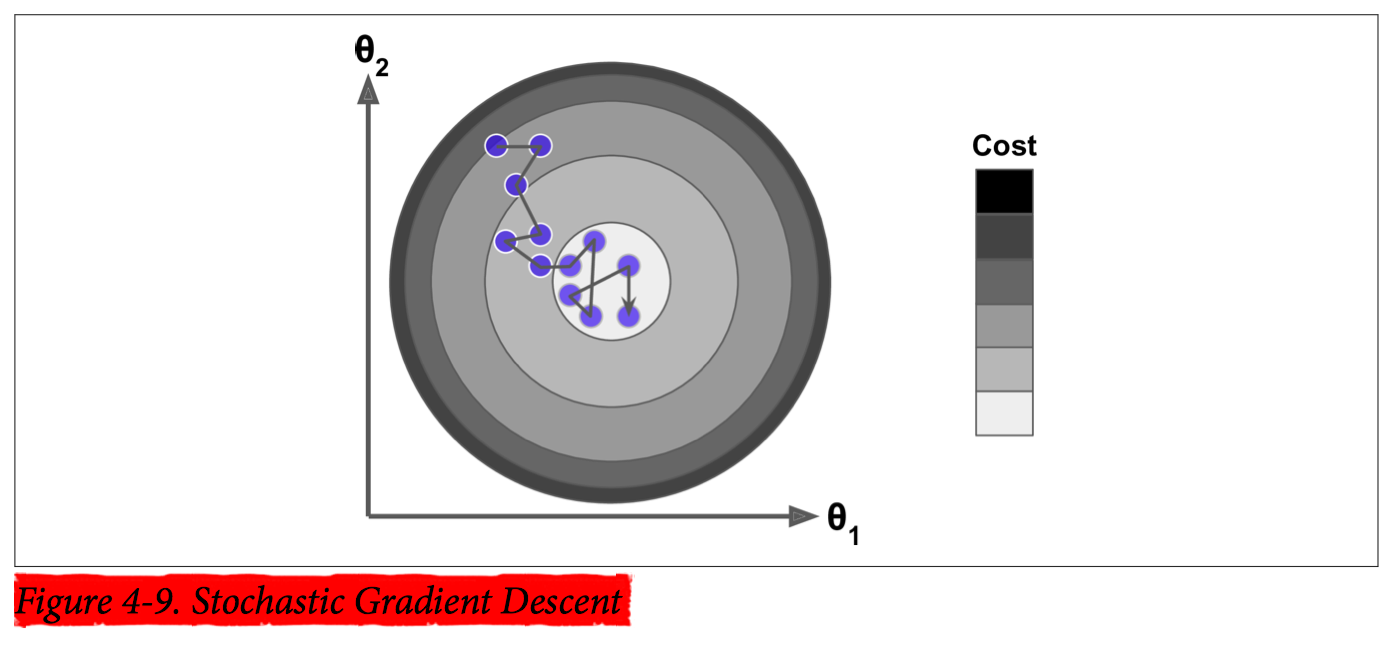

When the cost function is very irregular, this can actually help the algorithm jump out of local minima, so `Stochastic GD` has a better chance of finding the global minimum than `Batch GD` does.

Therefore randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum. One solution to this dilemma is to gradually reduce the learning rate. The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller, allowing the algorithm to settle at the global minimum. This process is called `simulated annealing`. The function that determines the learning rate at each iteration is called the learning schedule. If the learning rate is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. If the learning rate is reduced too slowly, you may jump around the minimum for a long time and end up with a suboptimal solution if you halt training too early.

This code implements `Stochastic GD` using a simple learning schedule:

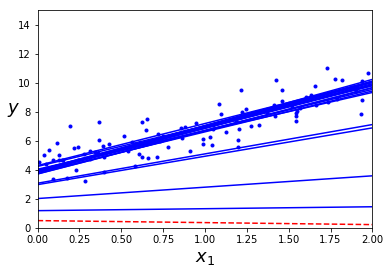

In [8]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()  

Note that since instances are picked randomly, some instances may be picked several times per epoch while others may not be picked at all. If you want to be sure that the algorithm goes through every instance at each epoch, another approach is to shuffle the training set, then go through it instance by instance, then shuffle it again, and so on. However, this generally converges more slowly.

To perform Linear Regression using `SGD` with Scikit-Learn, you can use the `SGDRegressor` class, which defaults to optimizing the squared error cost function. The following code runs 50 epochs, starting with a learning rate of 0.1, using the default learning schedule (different from the preceding one), and it does not use any regularization:

In [9]:
sgd_reg = sklearn.linear_model.SGDRegressor(max_iter=50, penalty=None, eta0=0.1) 
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([ 4.23166744]), array([ 2.79099659]))

### 4.2.3 Mini-batch Gradient Descent
The last `GD` algorithm we will look at is called `Mini-batch GD`. It is quite simple to understand: at each step, instead of computing the gradients based on the full training set (as in `Batch GD`) or based on just one instance (as in `Stochastic GD`), `Mini-batch GD` computes the gradients on small random sets of instances called `minibatches`. The main advantage of `Mini-batch GD` over `Stochastic GD` is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.

The algorithm’s progress in parameter space is less erratic than with `SGD`, especially with fairly large minibatches. As a result, `Mini-batch GD` will end up walking around a bit closer to the minimum than `SGD`. But, on the other hand, it may be harder for it to escape from local minima (in the case of problems that suffer from local minima, unlike Linear Regression as we saw earlier). 

In [10]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 10, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
        
theta

array([[ 4.25214635],
       [ 2.7896408 ]])

`Figure 4-11` shows the paths taken by the three `GD` algorithms in parameter space during training. They all end up near the minimum, but `Batch GD`’s path actually stops at the minimum, while both `Stochastic GD` and `Mini-batch GD` continue to walk around. However, don’t forget that `Batch GD` takes a lot of time to take each step, and `Stochastic GD` and `Mini-batch GD` would also reach the minimum if you used a good learning schedule:

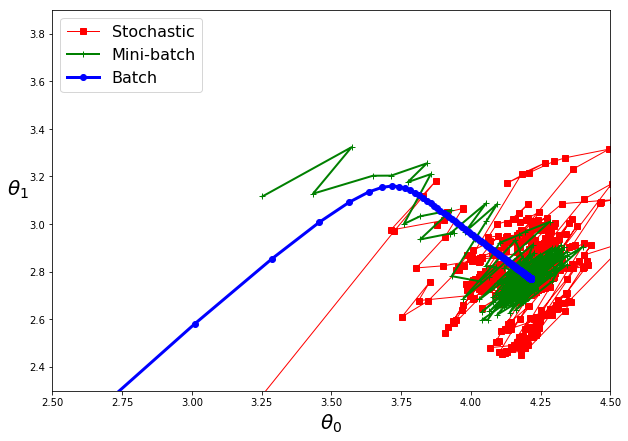

In [11]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(10,7))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

Let’s compare the algorithms we’ve discussed so far for Linear Regression:
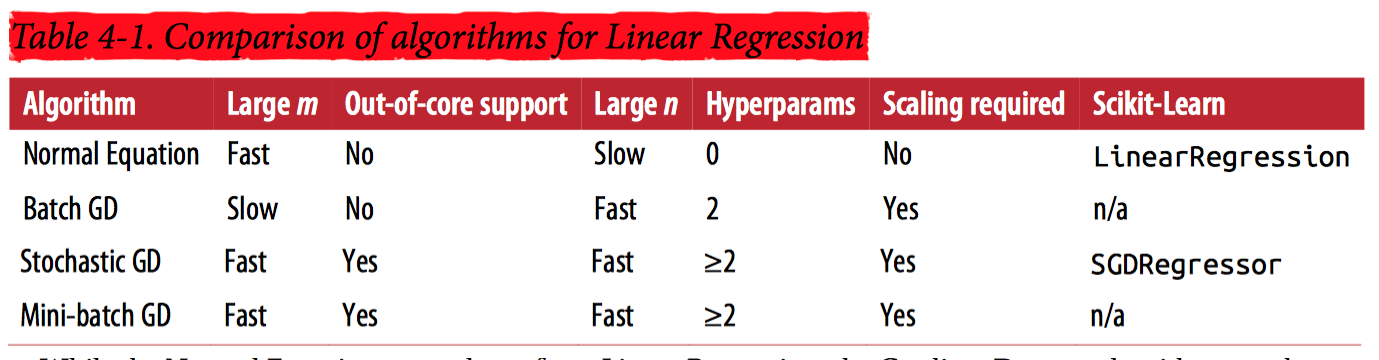

> There is almost no difference after training: all these algorithms end up with very similar models and make predictions in exactly the same way.

## 4.3 Polynomial Regression

What if your data is actually more complex than a simple straight line, you can also use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called `Polynomial Regression`.

Let’s generate some nonlinear data, based on a simple quadratic equation plus some noise ($y = ax^2 + bx + c + noise$):

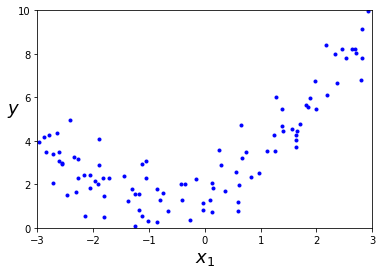

In [12]:
m = 100
np.random.seed(42)
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [13]:
poly_features = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

`X_poly` now contains the original feature of `X` plus the square of this feature. Now you can fit a LinearRegression model to this extended training data:

In [14]:
lin_reg = sklearn.linear_model.LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 1.78134581]), array([[ 0.93366893,  0.56456263]]))

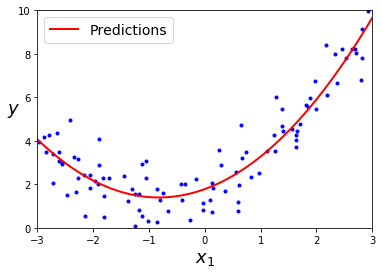

In [15]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

Not bad: the model estimates $y = 0.56x_1^2 + 0.93x_1 + 1.78$ when in fact the original function is $y = 0.5x_1^2 + 1.0x_1 + 2.0 + gaussian\_noise$.

Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do). This is made possible by the fact that `PolynomialFeatures` also adds all combinations of features up to the given degree. For example, if there were two features $a$ and $b$, `PolynomialFeatures` with $degree=3$ would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$ , but also the combinations $ab$, $a^2b$, and $ab^2$.

> `PolynomialFeatures(degree=d)` transforms an array containing $n$ features into an array containing $\frac{(n+d)!}{d!n!}$ features, where $n!$ is the factorial of $n$. Beware of the combinatorial explosion of the number of features!



## 4.4 Learning Curves
If you perform high-degree Polynomial Regression, you will likely fit the training data much better than with plain Linear Regression. For example, `Figure 4-14` applies a 300-degree polynomial model to the preceding training data, and compares the result with a pure linear model and a quadratic model ($2^{nd}$-degree polynomial). Notice how the 300-degree polynomial model wiggles around to get as close as possible to the training instances.

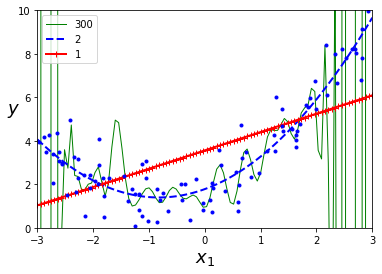

In [16]:
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = sklearn.preprocessing.StandardScaler()
    lin_reg = sklearn.linear_model.LinearRegression()
    polynomial_regression = sklearn.pipeline.Pipeline((
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ))
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

Of course, this high-degree Polynomial Regression model is severely overfitting the training data, while the linear model is underfitting it. The model that will generalize best in this case is the quadratic model. It makes sense since the data was generated using a quadratic model, but in general you won’t know what function generated the data, so how can you decide how complex your model should be? How can you tell that your model is overfitting or underfitting the data?

In `Chapter 2` you used cross-validation to get an estimate of a model’s generalization performance. If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

Another way is to look at the learning curves: these are plots of the model’s performance on the training set and the validation set as a function of the training set size. To generate the plots, simply train the model several times on different sized subsets of the training set. The following code defines a function that plots the learning curves of a model given some training data:

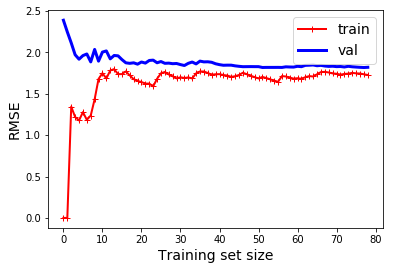

In [17]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(sklearn.metrics.mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(sklearn.metrics.mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

lin_reg = sklearn.linear_model.LinearRegression() 
plot_learning_curves(lin_reg, X, y)
plt.show()

This deserves a bit of explanation. First, let’s look at the performance on the training data: when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse. Now let’s look at the performance of the model on the validation data. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.

***These learning curves are typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high. If your model is underfitting the training data, adding more training examples will not help. You need to use a more complex model or come up with better features***.

Now let’s look at the learning curves of a $10^{th}$-degree polynomial model on the same data:

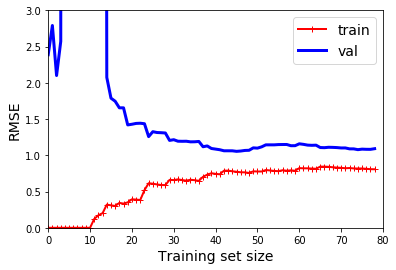

In [18]:
polynomial_regression = sklearn.pipeline.Pipeline((
        ("poly_features", sklearn.preprocessing.PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", sklearn.linear_model.LinearRegression()),
    ))

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
plt.show()                        # not shown

These learning curves look a bit like the previous ones, but there are two very important differences:
- The error on the training data is much lower than with the Linear Regression model.
- There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. However, if you used a much larger training set, the two curves would continue to get closer.

***One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.***



## 4.5 Regularized Linear Models
As we saw in `Chapters 1` and `Chapters 2`, a good way to reduce overfitting is to regularize the model: the fewer degrees of freedom it has, the harder it will be for it to overfit the data. For example, a simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model. We will now look at `Ridge Regression`, `Lasso Regression`, and `Elastic Net`, which implement three different ways to constrain the weights.

### 4.5.1 Ridge Regression
`Ridge Regression` (also called `Tikhonov regularization`) is a regularized version of Linear Regression: a regularization term equal to $\alpha\sum_{i=1}^{n}\theta_i^2$ is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to evaluate the model’s performance using the unregularized performance measure.

> It is quite common for the cost function used during training to be different from the performance measure used for testing. Apart from regularization, another reason why they might be different is that a good training cost function should have optimization-friendly derivatives, while the performance measure used for testing should be as close as possible to the final objective. A good example of this is a classifier trained using a cost function such as the log loss (discussed in a moment) but evaluated using precision/recall.

The hyperparameter $\alpha$ controls how much you want to regularize the model. If $\alpha = 0$ then Ridge Regression is just Linear Regression. If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean. Ridge Regression cost function:
- $j(\theta) = MSE(\theta)+\alpha\frac{1}{2}\sum_{i=1}^{n}\theta_i^2$

Note that the bias term $\theta_0$ is not regularized (the sum starts at $i = 1$, not $0$). If we define $\mathrm{w}$ as the vector of feature weights ($\theta_1$ to $\theta_n$), then the regularization term is simply equal to $\frac{1}{2}(\lVert\mathrm{w}\lVert_2)^2$, where $\lVert \cdot \rVert_2$ represents the $\ell_2$ norm of the weight vector. For Gradient Descent, just add $\alpha\mathrm{w}$ to the MSE gradient vector.

> It is important to scale the data before performing Ridge Regression, as it is sensitive to the scale of the input features. This is true of most regularized models.

`Figure 4-17` shows several Ridge models trained on some linear data using different $\alpha$ value. On the left, plain Ridge models are used, leading to linear predictions. On the right, the data is first expanded using PolynomialFeatures(degree=10), then it is scaled using a StandardScaler, and finally the Ridge models are applied to the resulting features: this is Polynomial Regression with Ridge regularization. Note how increasing $\alpha$ leads to flatter (i.e., less extreme, more reasonable) predictions; this reduces the model’s variance but increases its bias.

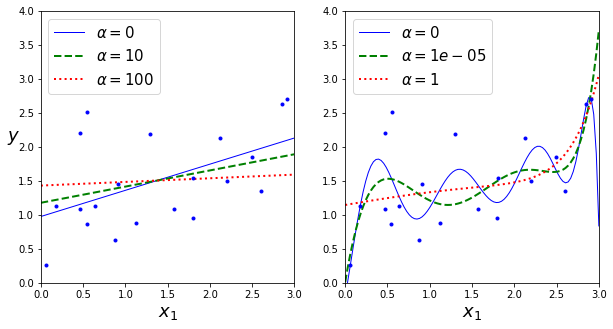

In [19]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else sklearn.linear_model.LinearRegression()
        if polynomial:
            model = sklearn.pipeline.Pipeline((
                    ("poly_features", sklearn.preprocessing.PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", sklearn.preprocessing.StandardScaler()),
                    ("regul_reg", model),
                ))
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(10,5))
plt.subplot(121)
plot_model(sklearn.linear_model.Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(sklearn.linear_model.Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.show()

As with Linear Regression, we can perform Ridge Regression either by computing a closed-form equation or by performing `GD`. The pros and cons are the same. `Equation 4-9` shows the closed-form solution (where $\mathrm{A}$ is the $n*n$ `identity matrix` except with a $0$ in the top-left cell, corresponding to the bias term):
- $\hat{\theta} = (X^T\cdot X + \alpha\mathrm{A})^{-1}\cdot X^T \cdot y$

Here is how to perform Ridge Regression with Scikit-Learn using a closed-form solution (a variant of `Equation 4-9` using a matrix factorization technique by `André-Louis Cholesky`):

In [20]:
ridge_reg = sklearn.linear_model.Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[ 1.55071465]])

And using `Stochastic Gradient Descent`:

In [21]:
sgd_reg = sklearn.linear_model.SGDRegressor(max_iter=5, penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([ 1.12795912])

The penalty hyperparameter sets the type of regularization term to use. Specifying "l2" indicates that you want `SGD` to add a regularization term to the cost function equal to half the square of the $\ell_2$ norm of the weight vector: this is simply Ridge Regression.

### 4.5.2 Lasso Regression
`Least Absolute Shrinkage and Selection Operator Regression` (simply called `Lasso Regression`) is another regularized version of Linear Regression: just like Ridge Regression, it adds a regularization term to the cost function, but it uses the $\ell_1$ norm of the weight vector instead of half the square of the $\ell_2$ norm (see Equation 4-10):
- $J(\theta) = MSE(\theta) + \alpha\sum_{i=1}^{n}|\theta_i|$

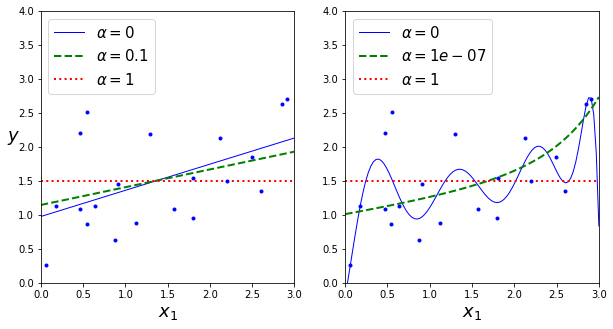

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plot_model(sklearn.linear_model.Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(sklearn.linear_model.Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)
plt.show()

An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the least important features (i.e., set them to zero). For example, the dashed line in the right plot (with $\alpha = 10^{-7}$) looks quadratic, almost linear: all the weights for the high-degree polynomial features are equal to zero. In other words, Lasso Regression automatically performs feature selection and outputs a sparse model (i.e., with few nonzero feature weights).

*You can get a sense of why this is the case by looking at `Figure 4-19`: on the top-left plot, the background contours (ellipses) represent an unregularized MSE cost function ($\alpha = 0$), and the white circles show the `Batch GD` path with that cost function. The foreground contours (diamonds) represent the $\ell_1$ penalty, and the triangles show the BGD path for this penalty only ($\alpha\to\infty$). Notice how the path first reaches $\theta_1 = 0$, then rolls down a gutter until it reaches $\theta_2 = 0$. On the top-right plot, the contours represent the same cost function plus an $\ell_1$ penalty with $\alpha = 0.5$. The global minimum is on the $\theta_2 = 0$ axis. BGD first reaches $\theta_2 = 0$, then rolls down the gutter until it reaches the global minimum. The two bottom plots show the same thing but uses an $\ell_2$ penalty instead. The regularized minimum is closer to $\theta = 0$ than the unregularized minimum, but the weights do not get fully eliminated*.

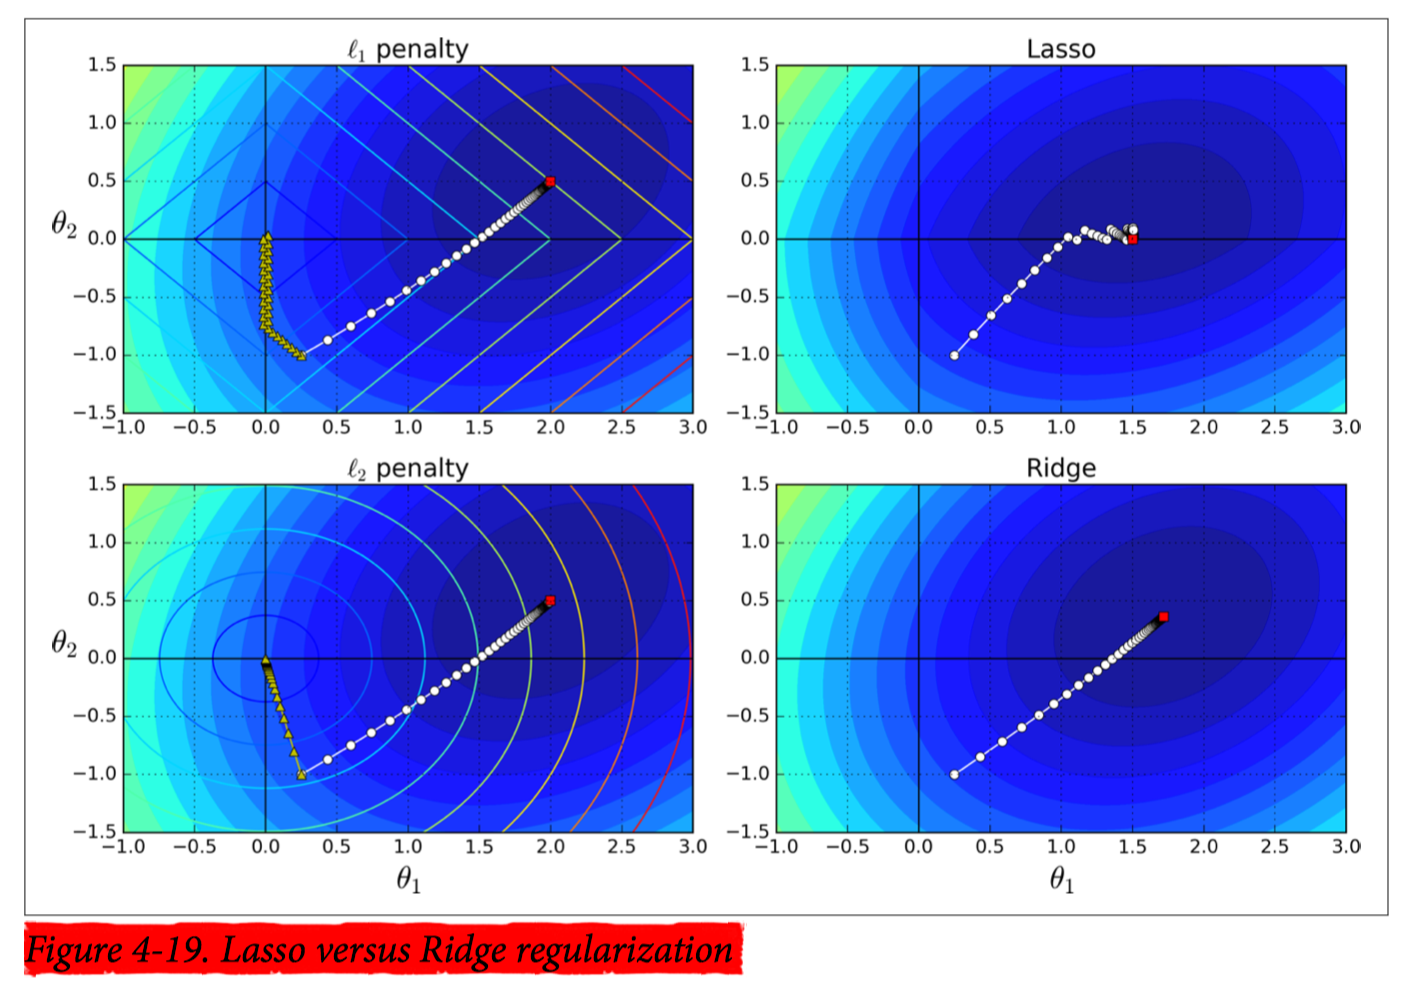

> On the Lasso cost function, the BGD path tends to bounce across the gutter toward the end. This is because the slope changes abruptly at $\theta_2 = 0$. You need to gradually reduce the learning rate in order to actually converge to the global minimum.

The Lasso cost function is not differentiable at $\theta_i = 0$ (for i = 1, 2, ⋯, n), but `GD` still works fine if you use a subgradient vector $\mathrm{g}$ instead when any $\theta_i = 0$. `Equation 4-11` shows a subgradient vector equation you can use for `GD` with the Lasso cost function:
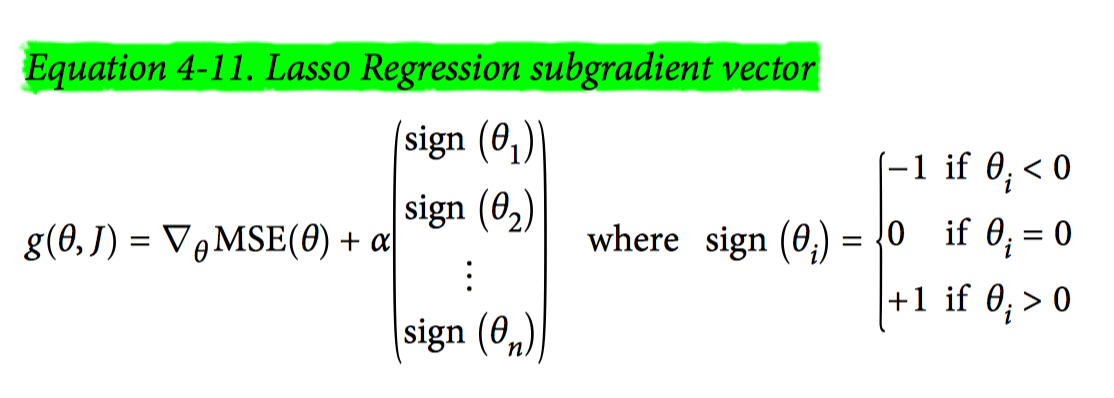

Here is a small Scikit-Learn example using the Lasso class. Note that you could instead use an `SGDRegressor(penalty="l1")`.

In [23]:
lasso_reg = sklearn.linear_model.Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([ 1.53788174])

### 4.5.3 Elastic Net
Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio $\mathrm{r}$. When $\mathrm{r} = 0$, Elastic Net is equivalent to Ridge Regression, and when $\mathrm{r} = 1$, it is equivalent to Lasso Regression (see `Equation 4-12`):
- $J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^{n}|\theta_i| + \frac{1-r}{2}\alpha\sum_{i=1}^{n}\theta_i^2$

So when should you use Linear Regression, Ridge, Lasso, or Elastic Net? It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain Linear Regression. Ridge is a good default, but if you suspect that only a few features are actually useful, you should prefer Lasso or Elastic Net since they tend to reduce the useless features’ weights down to zero as we have discussed. In general, Elastic Net is preferred over Lasso since Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

Here is a short example using Scikit-Learn’s ElasticNet (`l1_ratio` corresponds to the mix ratio $\mathrm{r}$):

In [24]:
elastic_net = sklearn.linear_model.ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([ 1.54333232])

### 4.5.4 Early Stopping
A very different way to regularize iterative learning algorithms such as `GD` is to stop training as soon as the validation error reaches a minimum. This is called early stopping. `Figure 4-20` shows a complex model (in this case a high-degree Polynomial Regression model) being trained using `Batch GD`. As the epochs go by, the algorithm learns and its prediction error (RMSE) on the training set naturally goes down, and so does its prediction error on the validation set. However, after a while the validation error stops decreasing and actually starts to go back up. This indicates that the model has started to overfit the training data. With early stopping you just stop training as soon as the validation error reaches the minimum. It is such a simple and efficient regularization technique that Geoffrey Hinton called it a “beautiful free lunch.”

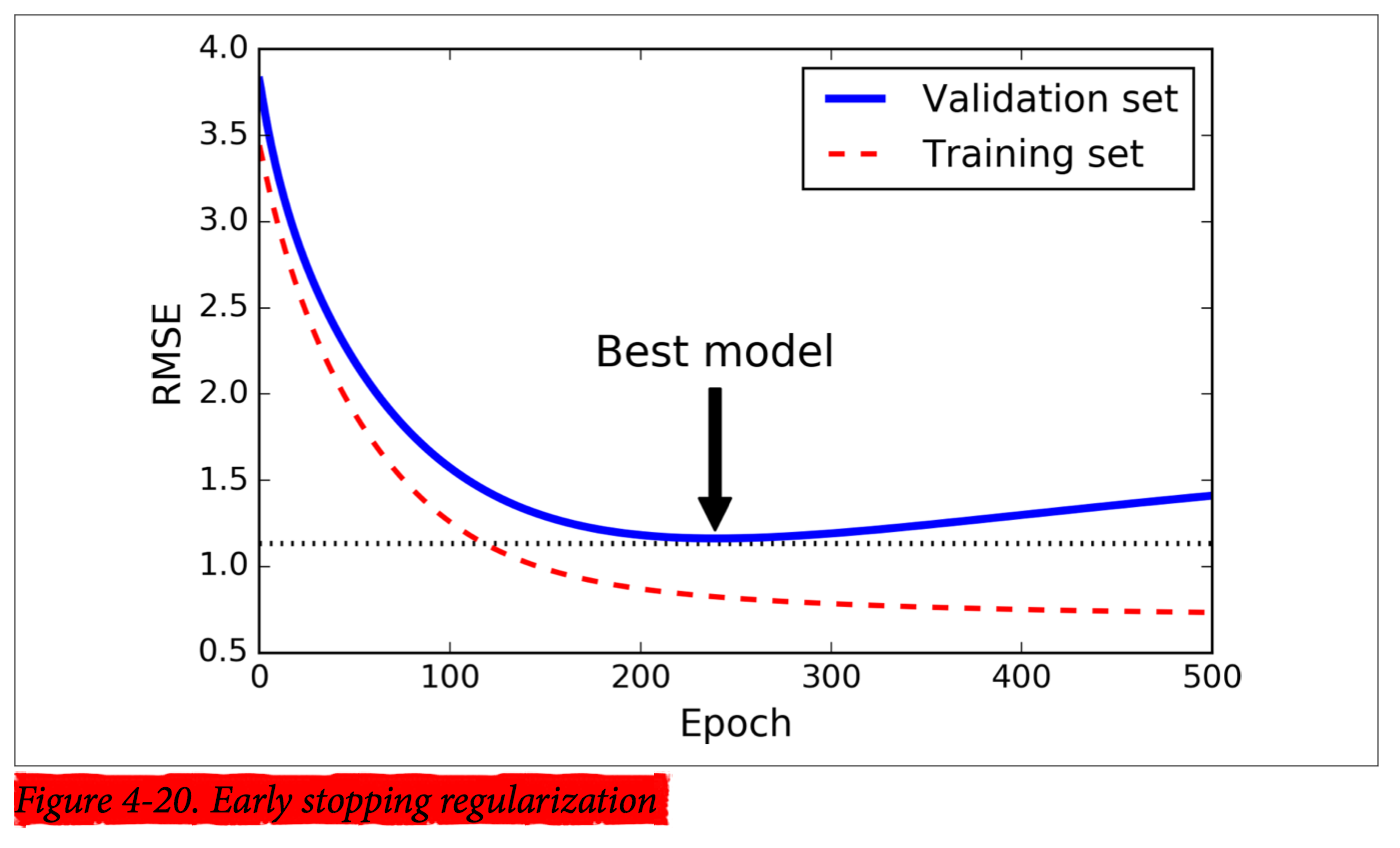

> With Stochastic and Mini-batch GD, the curves are not so smooth, and it may be hard to know whether you have reached the minimum or not. One solution is to stop only after the validation error has been above the minimum for some time (when you are confident that the model will not do any better), then roll back the model parameters to the point where the validation error was at a minimum.

Here is a basic implementation of early stopping:
```python
from sklearn.base import clone

sgd_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None, 
                       learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf") 
best_epoch = None 
best_model = None 

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # continues where it left off 
    y_val_predict = sgd_reg.predict(X_val_poly_scaled) 
    val_error = mean_squared_error(y_val_predict, y_val) 
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
```

*Note that with `warm_start=True`, when the `fit()` method is called, it just continues training where it left off instead of restarting from scratch.*

## 4.6 Logistic Regression
As we discussed in `Chapter 1`, some regression algorithms can be used for classification as well (and vice versa). Logistic Regression is commonly used to estimate the probability that an instance belongs to a particular class. If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), or else it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). This makes it a binary classifier.

### 4.6.1 Estimating Probabilities
Just like a Linear Regression model, a Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the logistic of this result (see `Equation 4-13`):
- $\hat{p} = h_\theta(x) = \sigma(\theta^T\cdot X)$

The logistic--also called the logit, noted $\sigma(\cdot)$ -- is a sigmoid function that outputs a number between 0 and 1:
- $\sigma(t) = \frac{1}{1+e^{-t}}$

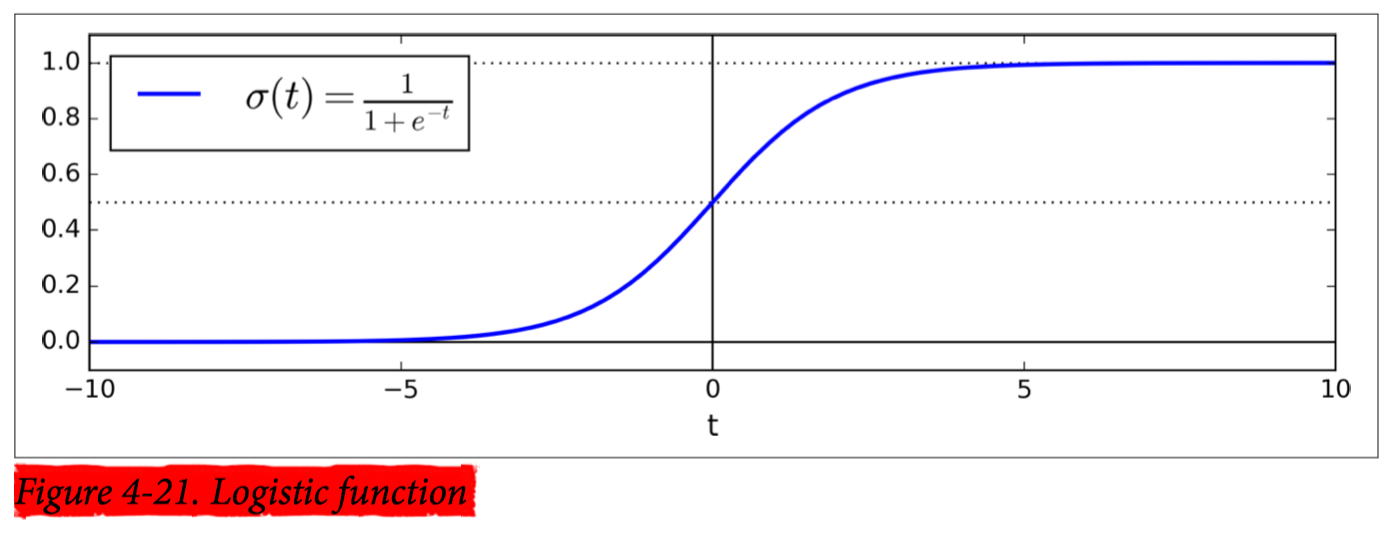

Once the Logistic Regression model has estimated the probability $\hat{p} = h_\theta(x)$ that an instance $x$ belongs to the positive class, it can make its prediction $\hat{y}$ easily:
- $\hat{y} = \begin{bmatrix} \begin{array}{*{20}{c}}{0, \hat{p} \lt 0.5}\\{1, \hat{p} \ge 0.5}\end{array} \end{bmatrix}$

Notice that $\sigma(t) \lt 0.5$ when $t \lt 0$, and $\sigma(t) \ge 0.5$ when $t \ge 0$, so a Logistic Regression model predicts 1 if $\theta^T \cdot x$ is positive, and 0 if it is negative.

### 4.6.2 Training and Cost Function
Now you know how a Logistic Regression model estimates probabilities and makes predictions. But how is it trained? The objective of training is to set the parameter vector $\theta$ so that the model estimates high probabilities for positive instances and low probabilities for negative instances. This idea is captured by the cost function shown in `Equation 4-16` for a single training instance $\mathrm{x}$:
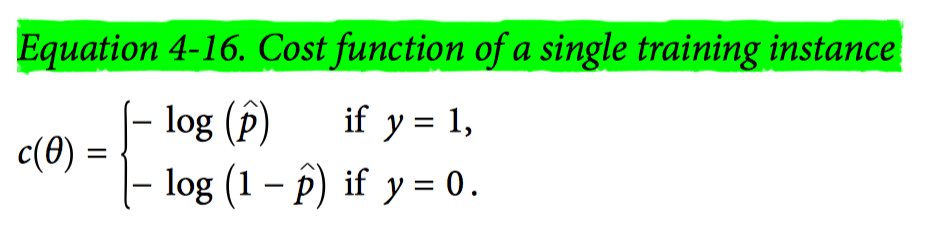

This cost function makes sense because $-log(t)$ grows very large when $t$ approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance, and it will also be very large if the model estimates a probability close to 1 for a negative instance. On the other hand, $-log(t)$ is close to 0 when $t$ is close to 1, so the cost will be close to 0 if the estimated probability is close to 0 for a negative instance or close to 1 for a positive instance, which is precisely what we want.

The cost function over the whole training set is simply the average cost over all training instances. It can be written in a single expression (as you can verify easily), called the `log loss`:
- $J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}\log(\hat{p}^{(i)}) + (1-y^{(i)})\log(1-\hat{p}^{(i)}]$

The bad news is that there is no known closed-form equation to compute the value of $\theta$ that minimizes this cost function (there is no equivalent of the Normal Equation). But the good news is that this cost function is convex, so `GD` (or any other optimization algorithm) is guaranteed to find the global minimum. The partial derivatives of the cost function with regards to the $j^{th}$ model parameter $\theta_j$ is:
- $\frac{\partial}{\partial\theta_j}J(\theta)=-\frac{1}{m}\sum_{i=1}^{m}(\sigma(\theta^T\cdot x^{(i)})-y^{(i)})x_j^{(i)}$

For each instance it computes the prediction error and multiplies it by the $j^{th}$ feature value, and then it computes the average over all training instances. Once you have the gradient vector containing all the partial derivatives you can use it in the `Batch GD` algorithm. That’s it: you now know how to train a Logistic Regression model. For `Stochastic GD` you would of course just take one instance at a time, and for `Mini-batch GD` you would use a mini-batch at a time.

### 4.6.3 Decision Boundaries
Let’s use the iris dataset to illustrate Logistic Regression:
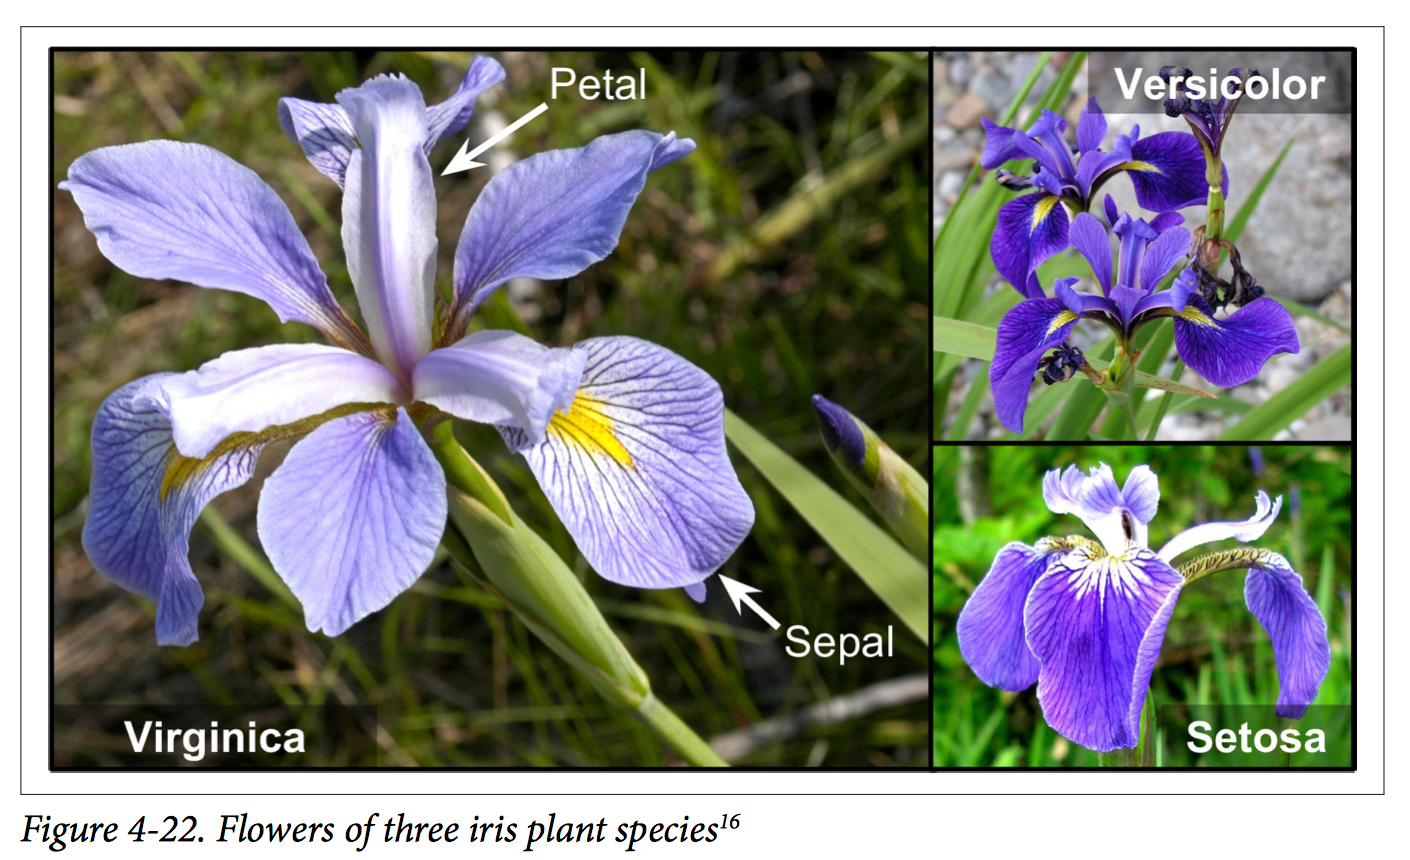

Let’s try to build a classifier to detect the Iris-Virginica type based only on the petal width feature:

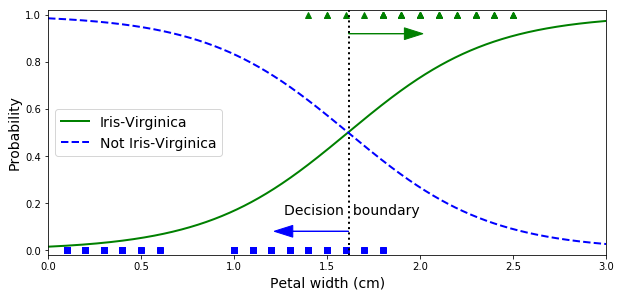

In [25]:
iris = sklearn.datasets.load_iris()

X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(np.int) # 1 if Iris-Virginica, else 0

log_reg = sklearn.linear_model.LogisticRegression() 
log_reg.fit(X, y)

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(10, 4.5))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

The petal width of Iris-Virginica flowers (represented by triangles) ranges from `1.4cm` to `2.5cm`, while the other iris flowers (represented by squares) generally have a smaller petal width, ranging from `0.1cm` to `1.8cm`. Notice that there is a bit of overlap. Above about `2cm` the classifier is highly confident that the flower is an IrisVirginica (it outputs a high probability to that class), while below 1 cm it is highly confident that it is not an Iris-Virginica (high probability for the “Not Iris-Virginica” class). In between these extremes, the classifier is unsure. However, if you ask it to predict the class (using the predict() method rather than the predict_proba() method), it will return whichever class is the most likely. Therefore, there is a decision boundary at around `1.6cm` where both probabilities are equal to 50%: if the petal width is higher than `1.6cm`, the classifier will predict that the flower is an IrisVirginica, or else it will predict that it is not (even if it is not very confident):

In [26]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

In [27]:
decision_boundary

array([ 1.61561562])

`Figure 4-24` shows the same dataset but this time displaying two features: petal width and length. Once trained, the Logistic Regression classifier can estimate the probability that a new flower is an Iris-Virginica based on these two features. The dashed line represents the points where the model estimates a 50% probability: this is the model’s decision boundary. Note that it is a linear boundary. Each parallel line represents the points where the model outputs a specific probability, from 15% (bottom left) to 90% (top right). All the flowers beyond the top-right line have an over 90% chance of being Iris-Virginica according to the model.

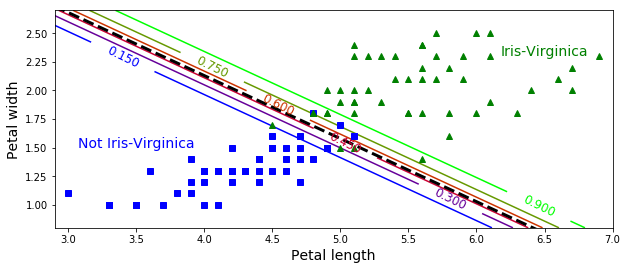

In [28]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = sklearn.linear_model.LogisticRegression(C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

Just like the other linear models, Logistic Regression models can be regularized using $\ell_1$ or $\ell_2$ penalties. Scitkit-Learn actually adds an $\ell_2$ penalty by default.

The hyperparameter controlling the regularization strength of a Scikit-Learn LogisticRegression model is `C`. The higher the value of `C`, the less the model is regularized.

### 4.6.4 Softmax Regression
The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers. This is called `Softmax Regression`, or `Multinomial Logistic Regression`.

The idea is quite simple: when given an instance $x$, the Softmax Regression model first computes a score $s_k(x)$ for each class $k$, then estimates the probability of each class by applying the `softmax function` (also called the `normalized exponential`) to the scores. The equation to compute $s_k(x) = \theta_k^T\cdot x$ should look familiar:
- $s_k(x) = \theta_k^T\cdot x$ 

Note that each class has its own dedicated parameter vector $\theta_k$ . All these vectors are typically stored as rows in a parameter matrix $\Theta$.

Once you have computed the score of every class for the instance $x$, you can estimate the probability $\hat{p}_k$ that the instance belongs to class $k$ by running the scores through the softmax function -- it computes the exponential of every score, then normalizes them (dividing by the sum of all the exponentials):
- $\hat{p}_k = \sigma(s(x))_k= \frac{exp(s_k(x))}{\sum_{j=1}^{K}exp(s_j(x))}$

> - $K$ is the number of classes.
> - $s(x)$ is a vector containing the scores of each class for the instance $x$.
> - $\sigma(s(x))_k$ is the estimated probability that the instance $x$ belongs to class $k$ given the scores of each class for that instance.

Just like the Logistic Regression classifier, the Softmax Regression classifier predicts the class with the highest estimated probability:
- $\hat{y} = \underset{x}{\mathrm{argmin}}\ \sigma(s(x))_k = \underset{x}{\mathrm{argmin}}\  s_k(x) = \underset{x}{\mathrm{argmin}}\ (\theta^T\cdot x)$

> - The $argmax$ operator returns the value of a variable that maximizes a function. In this equation, it returns the value of $k$ that maximizes the estimated probability $\sigma(s(x))_k$.

The Softmax Regression classifier predicts only one class at a time so it should be used only with mutually exclusive classes such as different types of plants. You cannot use it to recognize multiple people in one picture.

Let’s take a look at training. The objective is to have a model that estimates a high probability for the target class (and consequently a low probability for the other classes). Minimizing the cost function shown in `Equation 4-22`, called the cross entropy, should lead to this objective because it penalizes the model when it estimates a low probability for a target class. Cross entropy is frequently used to measure how well a set of estimated class probabilities match the target classes:
- $J(\Theta) = -\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_k^{(i)}log(\hat{p}_k^{(i)})$
> - $y_k^{(i)}$ is equal to 1 if the target class for the $i^{(th)}$ instance is $k$; otherwise, it is equal to 0.

Notice that when there are just two classes ($K = 2$), this cost function is equivalent to the Logistic Regression’s cost function (log loss; see `Equation 4-17`).

The gradient vector of this cost function with regards to $\theta_k$ is given by `Equation 4-23`:
- $\nabla_{\theta_k}J(\Theta) = \frac{1}{m}\sum_{i=1}^{m}(\hat{p}_k^{(i)}-y_k^{(i)})x^{(i)}$

Now you can compute the gradient vector for every class, then use Gradient Descent (or any other optimization algorithm) to find the parameter matrix Θ that minimizes the cost function.

Let’s use Softmax Regression to classify the iris flowers into all three classes. Scikit-Learn’s LogisticRegression uses one-versus-all by default when you train it on more than two classes, but you can set the multi_class hyperparameter to "multinomial" to switch it to Softmax Regression instead. You must also specify a solver that supports Softmax Regression, such as the "lbfgs" solver (see Scikit-Learn’s documentation for more details). It also applies $\ell_2$ regularization by default, which you can control using the hyperparameter `C`:

In [29]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = sklearn.linear_model.LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10) 
softmax_reg.fit(X, y)

# ask the model an iris with 5 cm long and 2 cm wide petals what type of iris it is
# it will answer Iris-Virginica (class 2)
softmax_reg.predict([[5, 2]])

array([2])

In [30]:
softmax_reg.predict_proba([[5, 2]])

array([[  6.33134077e-07,   5.75276067e-02,   9.42471760e-01]])

`Figure 4-25` shows the resulting decision boundaries, represented by the background colors. Notice that the decision boundaries between any two classes are linear. The figure also shows the probabilities for the Iris-Versicolor class, represented by the curved lines (e.g., the line labeled with 0.450 represents the 45% probability boundary). Notice that the model can predict a class that has an estimated probability below 50%. For example, at the point where all decision boundaries meet, all classes have an equal estimated probability of 33%.
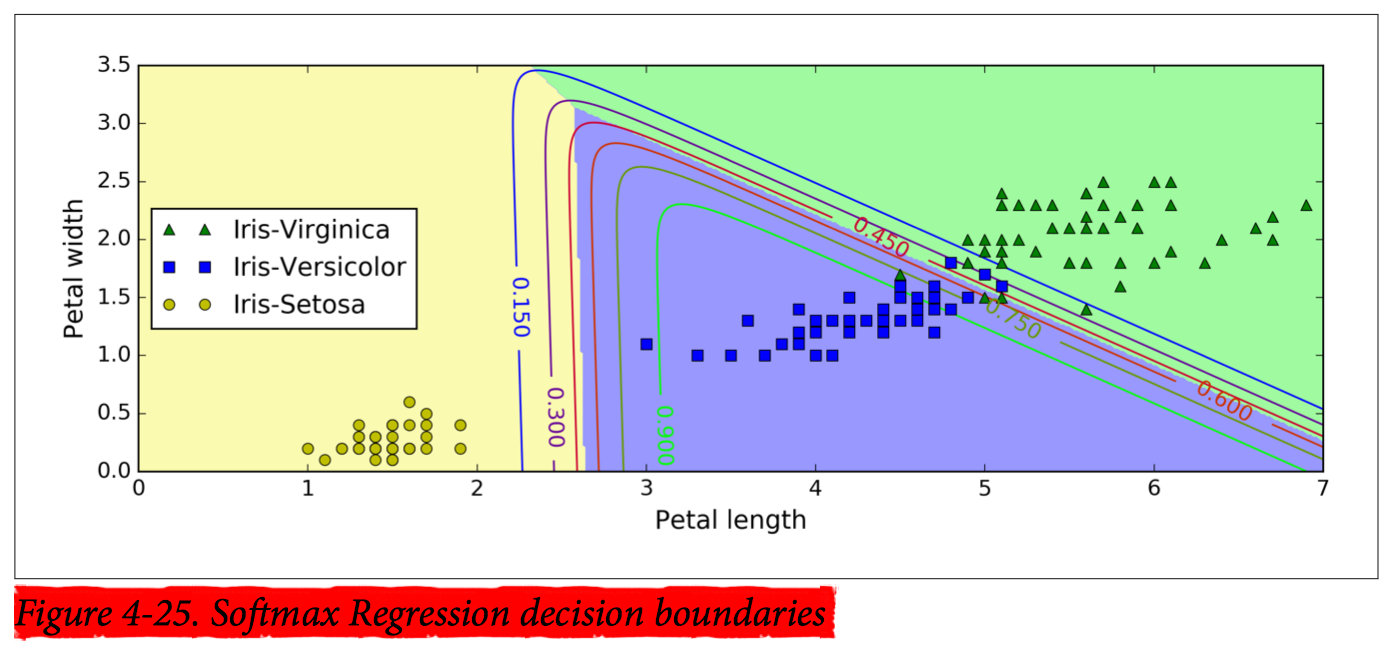